In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA


/tmp/ipykernel_105954/1819617421.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
window = 5

file_path = './in/copper_log_returns_{}d_final.csv'.format(window)
df = pd.read_csv(file_path)
df

,Date,LMCADS03,LMCADY,DXY,SPX,BCOM,MXWD,XAU,XAG,LMCADY_acu_5d_log,LMCADY_std_5d_log
0,2003-01-02,0.019048,0.019834,0.010739,0.032661,0.025337,0.023209,-0.005763,0.007918,0.040542,0.007181
1,2003-01-03,0.013121,0.013478,-0.004965,-0.000484,0.014288,0.003782,0.014915,0.014833,0.015400,0.010511
2,2003-01-06,0.010804,0.010262,-0.004891,0.022226,-0.016118,0.018549,0.000000,0.001533,0.011601,0.009986
3,2003-01-07,-0.004616,-0.004479,0.005867,-0.006566,-0.002697,-0.008853,-0.011453,-0.020109,0.027062,0.009745
4,2003-01-08,0.009822,0.009771,-0.006848,-0.014186,0.004093,-0.014657,0.018206,0.010363,0.023340,0.009467
...,...,...,...,...,...,...,...,...,...,...,...
5545,2024-04-08,0.008751,0.007897,-0.001535,-0.000375,0.000216,0.001968,0.003975,0.013549,0.023212,0.010161
5546,2024-04-09,0.000637,0.000161,0.000096,0.001444,-0.001109,0.001528,0.005861,0.010767,0.007737,0.013632
5547,2024-04-10,-0.004630,-0.004594,0.010506,-0.009502,0.000649,-0.008312,-0.007997,-0.007269,0.026616,0.014112
5548,2024-04-11,-0.003420,-0.003312,0.000285,0.007417,-0.005083,0.002714,0.016352,0.017577,0.046886,0.013921


In [3]:
df['Date'] = pd.to_datetime(df['Date'])

df = df.sort_values(by='Date')

df = df.reset_index(drop=True)

targ = 'LMCADY_acu_{}d_log'.format(window)

time_series = df[targ]

In [4]:
LMCADY_train, LMCADY_test = train_test_split(time_series, test_size=0.005, shuffle=False)

In [5]:
def find_best_arima(time_series, max_q=20, best_p = 100):

    best_aic = float('inf')
    best_params = None

    for q in range(max_q + 1):
        try:
            model_arima = ARIMA(time_series, order=(best_p, 0, q))
            result_arima = model_arima.fit()

            aic = result_arima.aic
            print('ARIMA{} - AIC:{}'.format((best_p, 0, q), aic))

            if aic < best_aic:
                best_aic = aic
                best_params = (best_p, q)

        except Exception as e:
            continue

    return best_params, best_aic

In [6]:
if window == 5:
    best_p = 58 
elif window == 10:
    best_p = 59
elif window == 20:
    best_p = 100


# best_params, best_aic = find_best_arima(time_series,best_p=best_p)
# best_params, best_aic

# ((0, 5), -29830.06289218084)

best_params = (best_p, 10)
best_aic = -29830.06289218084

In [7]:
def evaluate_arima_model(train_series, test_series, p, q):

    if not isinstance(train_series.index, pd.DatetimeIndex):
        train_series.index = pd.RangeIndex(start=0, stop=len(train_series))

    predictions = []

    current_train = train_series.copy()

    for actual in test_series:
        model_arima = ARIMA(current_train, order=(p, 0, q))
        model_fit = model_arima.fit()

        prediction = model_fit.predict(start=len(current_train), end=len(current_train))
        print('Prediction: {:.6f}'.format(prediction.iloc[0]))

        predictions.append(prediction.iloc[0])

        current_train = pd.concat([current_train, pd.Series([actual], index=[len(current_train)])])

    return pd.Series(predictions, index=test_series.index)

In [8]:
def calculate_rmse(predictions, actual):
    if len(predictions) != len(actual):
        raise ValueError("Las predicciones y los valores reales deben tener la misma longitud.")

    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    return rmse

In [9]:
# p, q = best_params
p = 5
q = 5
print('p:', p, 'q:', q)
LMCADY_predictions = evaluate_arima_model(LMCADY_train, LMCADY_test, p, q)
LMCADY_rmse = calculate_rmse(LMCADY_predictions, LMCADY_test)

p: 5 q: 5


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: 0.008661


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: 0.032092


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: 0.035675


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: 0.044546


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: 0.047921


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: 0.004674


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: 0.005313


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: -0.012897


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: -0.028102


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: -0.012841


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: -0.007549


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: -0.009736


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: 0.002950


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: 0.000113


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: 0.001735


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: 0.015907


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: 0.040878


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: 0.052897


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: 0.048592


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: 0.044107


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: 0.014752


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: 0.000812


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: 0.001970


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: 0.003940


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: 0.020102


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: 0.012880


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction: 0.029412
Prediction: 0.033192


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [10]:
def plot_predictions(test_series, predictions, title):
    plt.figure(figsize=(12, 6))

    plt.plot(test_series.index, test_series, label="Actual", marker='o', linestyle='-')
    plt.plot(test_series.index, predictions, label="Predicted", marker='x', linestyle='--')

    plt.title(f"ARMA Model: {title}")
    plt.legend()
    plt.show()

In [11]:
LMCADY_rmse

0.012646124092462775

In [12]:
LMCADY_test.describe()['std']

0.025725924025968183

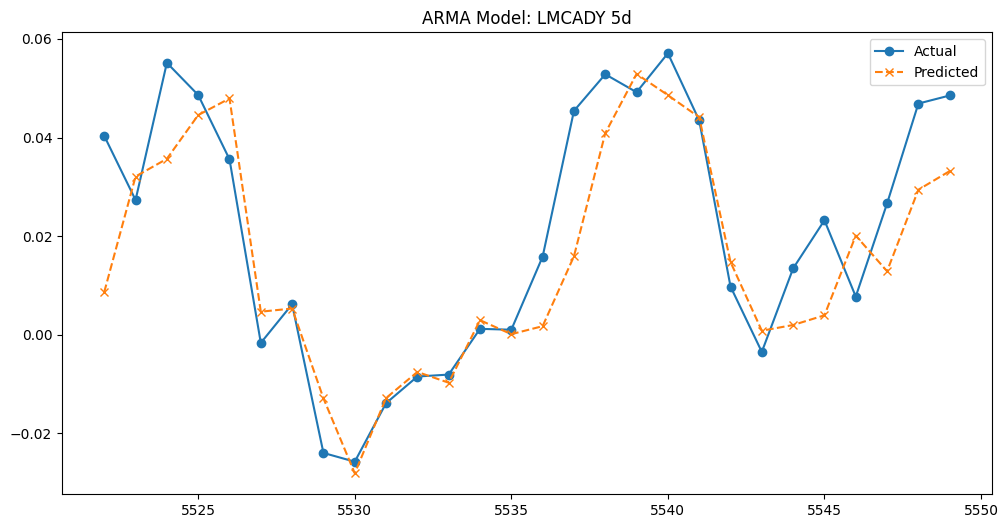

In [13]:
plot_predictions(LMCADY_test, LMCADY_predictions, "LMCADY {}d".format(window))